In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Importing and preparing the data

In [2]:
# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

#### Visualizing the data

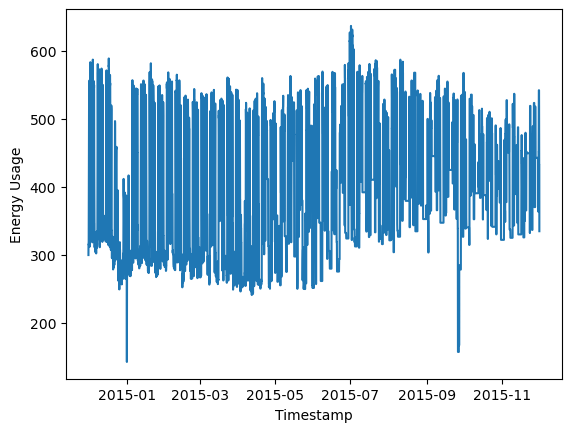

In [3]:
plt.plot(newData)
plt.xlabel('Timestamp')
plt.ylabel('Energy Usage')
plt.show()

#### Check for Stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(newData['Office_Garman'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Office_Garman):
    result=adfuller(Office_Garman)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [5]:
adfuller_test(newData['Office_Garman'])

ADF Test Statistic : -11.660973171965004
p-value : 1.9338052604326435e-21
#Lags Used : 37
Number of Observations Used : 8722
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Splitting the data for training and testing

In [24]:
# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]


#### Plotting the ACF and PACF

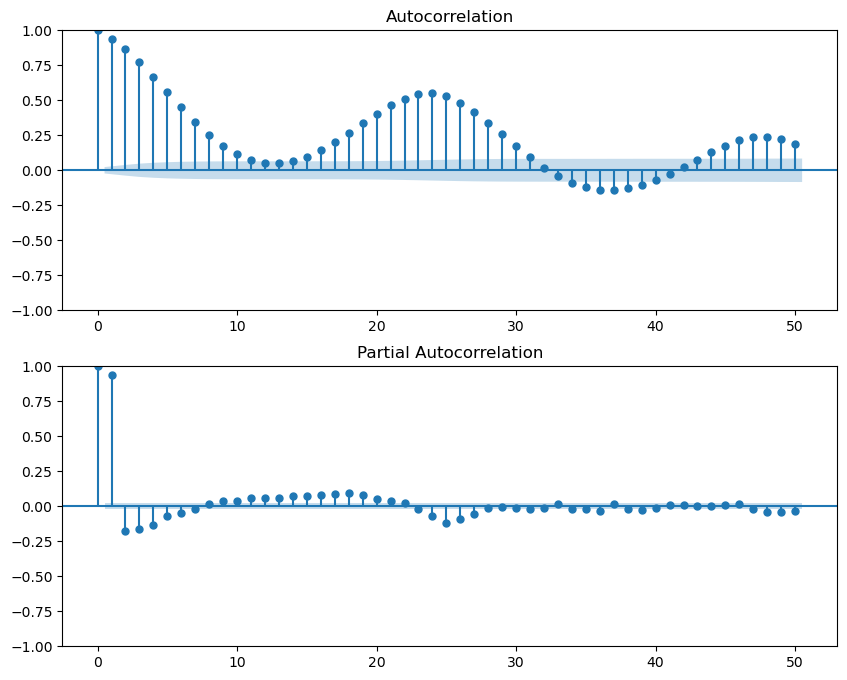

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train, ax=ax1, lags=50)
plot_pacf(train, ax=ax2, lags=50)
plt.show()

#### Deciding the order of the p,d,q using auto_arima function

In [8]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=24, max_q=24,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71237.907, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71483.157, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71332.660, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71360.346, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71481.158, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71218.470, Time=0.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71242.926, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=71206.130, Time=1.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=71204.132, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=71206.130, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=71208.111, Time=1.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=71202.132, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=71240.926, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=71204.130, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0

#### Fitting the ARIMA model (assuming there is no seasonality in the data)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fitting the ARIMA model
model = ARIMA(train, order=(3, 1, 0))
model_fit = model.fit()

# Printing the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Office_Garman   No. Observations:                 7296
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -35597.066
Date:                Wed, 24 May 2023   AIC                          71202.132
Time:                        18:59:16   BIC                          71229.711
Sample:                    12-01-2014   HQIC                         71211.615
                         - 09-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1194      0.014      8.584      0.000       0.092       0.147
ar.L2          0.1022      0.012      8.276      0.000       0.078       0.126
ar.L3          0.0747      0.011      6.758      0.000       0.053       0.096
sigma2      1014.1367      5.620    180.464      0.000    1003.123    1025.151
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             78800.12
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Evaluating the residuals

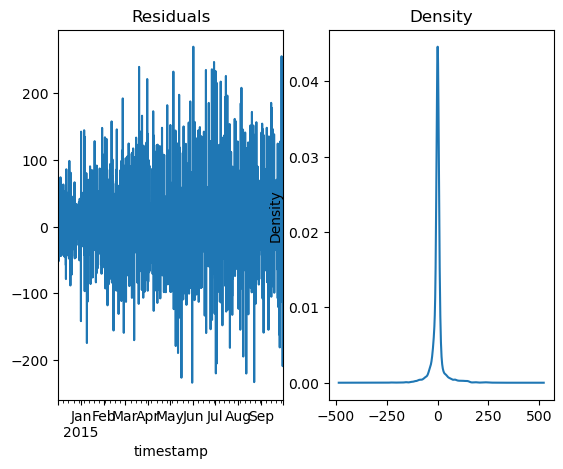

In [10]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

#### Predicting on the test set

In [11]:
# Make predictions on the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Display the predictions
print(predictions)


2015-09-30 00:00:00    301.196188
2015-09-30 01:00:00    304.790653
2015-09-30 02:00:00    310.560541
2015-09-30 03:00:00    326.200000
2015-09-30 04:00:00    326.200000
                          ...    
2015-11-30 19:00:00    336.947209
2015-11-30 20:00:00    336.947209
2015-11-30 21:00:00    336.947209
2015-11-30 22:00:00    336.947209
2015-11-30 23:00:00    336.947209
Freq: H, Name: predicted_mean, Length: 1488, dtype: float64


#### Plotting the predictions and actual data

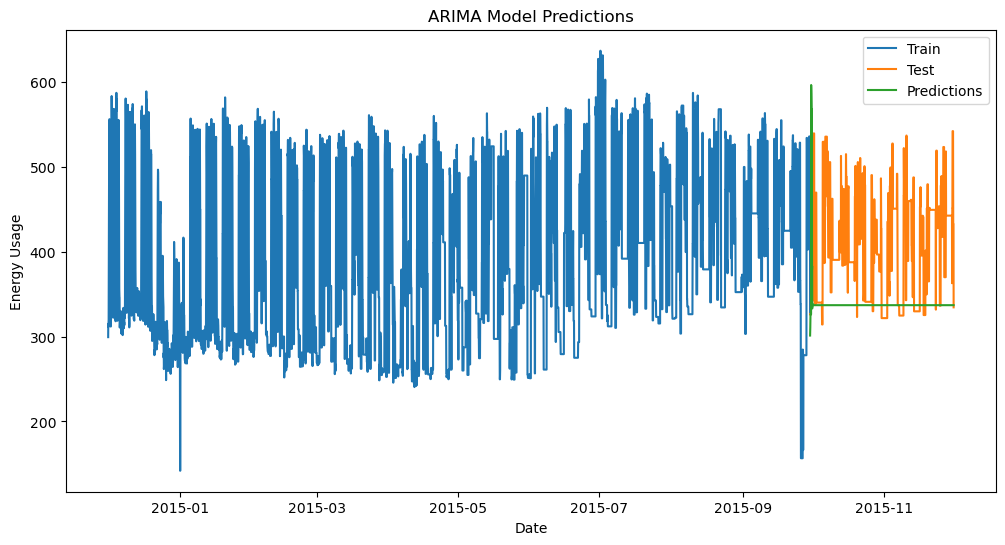

In [25]:
# Import the required libraries
import matplotlib.pyplot as plt

# Plotting the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(predictions.index, predictions.values, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()


#### Evaluating the model predictions

In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 73.27851601149429
mape - manual: 0.1636885059597816
rmse - manual: 92.61427539243624


#### #### Fitting the SARIMA model (now trying to incorporate the seasonality in the data)

In [33]:
import statsmodels.api as sm

In [34]:
model=sm.tsa.statespace.SARIMAX(train['Office_Garman'],order=(3, 1, 1),seasonal_order=(0,0,0,24))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87900D+00    |proj g|=  2.95743D-04

At iterate    5    f=  4.87899D+00    |proj g|=  1.55788D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   7.731D-06   4.879D+00
  F =   4.8789837092019672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [35]:
# Making predictions
sarima_predictions = results.get_forecast(steps=len(test))
sarima_predicted_values = sarima_predictions.predicted_mean


In [36]:
# Creating a DataFrame for SARIMA predictions
sarima_predictions_df = pd.DataFrame(sarima_predicted_values, index=test.index, columns=['Predictions'])


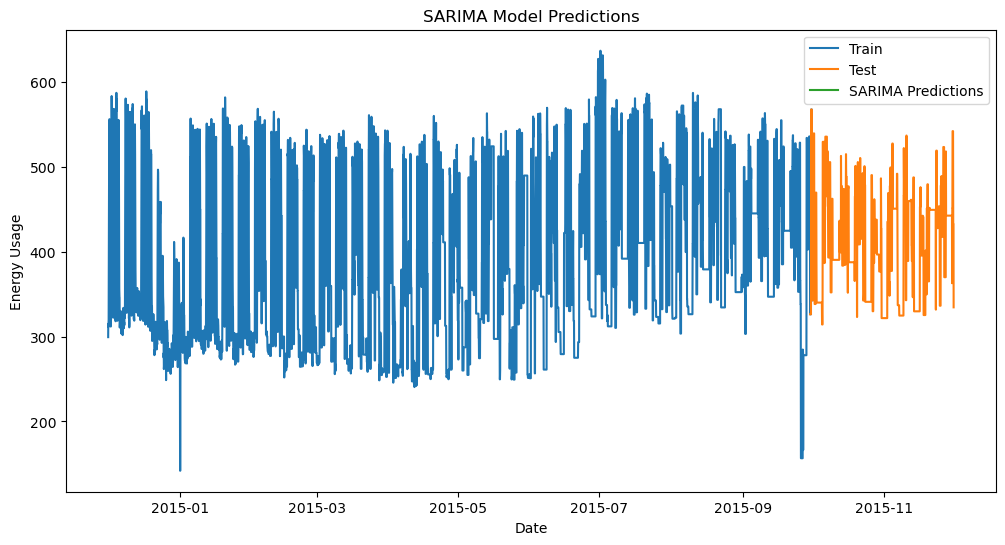

In [37]:
# Plotting the actual data and SARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(sarima_predictions_df.index, sarima_predictions_df['Predictions'], label='SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.show()
